## Setup and Imports

In [1]:
import os
import random
import json
from pathlib import Path
from typing import List, Tuple, Dict, Any, Optional
from collections import Counter

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    get_scheduler,
    DataCollatorWithPadding
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Setup output directory
OUTPUT_DIR = Path("output")
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"PyTorch: {torch.__version__}")
print(f"GPU Available: {torch.cuda.is_available()}")
print(f"GPU Device: {torch.cuda.get_device_name() if torch.cuda.is_available() else 'None'}")

/Users/adyasrivastava/amd/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch: 2.8.0
GPU Available: False
GPU Device: None


## Reproducibility and Configuration

In [2]:
def set_global_seed(seed: int = 42) -> None:
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed(42)

# Configuration
CONFIG = {
    'model_name': 'prajjwal1/bert-tiny',  # BERT-Tiny: 2 layers, 128 hidden, 2 heads
    'max_length': 128,
    'batch_size': 32,  # Larger batch size for better GPU utilization
    'learning_rate': 3e-5,
    'num_epochs': 15,
    'patience': 3,  # Early stopping patience
    'test_size': 0.2,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'csv_file': 'all_EN_calls.csv',
    's3_bucket': 'voicex-call-recordings'
}

## Dataset Class

In [3]:
class TranscriptDataset(Dataset):
    """Dataset class for transcript classification with proper type hints"""
    
    def __init__(
        self, 
        texts: List[str], 
        labels: List[int], 
        tokenizer: AutoTokenizer, 
        max_length: int = 128
    ) -> None:
        self.texts: List[str] = texts
        self.labels: List[int] = labels
        self.tokenizer: AutoTokenizer = tokenizer
        self.max_length: int = max_length
    
    def __len__(self) -> int:
        return len(self.texts)
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        text: str = str(self.texts[idx])
        label: int = int(self.labels[idx])
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.float)  # BCEWithLogitsLoss expects float
        }


## Data Processing and Stratification

In [4]:
def extract_user_text(transcript: List[Dict[str, Any]]) -> str:
    """Extract and combine all user utterances from transcript"""
    if not transcript:
        return ""
    
    user_texts: List[str] = []
    for utterance in transcript:
        if utterance.get("speaker", "").lower() == "user":
            content: str = utterance.get("content", "").strip()
            if content:
                user_texts.append(content)
    
    return " ".join(user_texts)

def prepare_stratified_data(
    call_data: List[Tuple[str, str, int]], 
    fuzzy_amd_instance,
    test_size: float = 0.2,
    random_state: int = 42
) -> Tuple[List[str], List[str], List[int], List[int], List[str], List[str]]:
    """
    Prepare stratified training data ensuring balanced representation
    """
    print("Preparing stratified training data...")
    
    # CRITICAL FIX: Set up call_data_map so _load_transcript can find transcript URLs
    fuzzy_amd_instance.call_data_map = {call_id: (transcript_url, duration) for call_id, transcript_url, duration in call_data}
    print(f"Set up call_data_map with {len(fuzzy_amd_instance.call_data_map)} entries")
    
    texts: List[str] = []
    labels: List[int] = []
    call_ids: List[str] = []
    
    # Process each call to get labels from rule-based system
    for call_id, transcript_url, duration in tqdm(call_data, desc="Processing transcripts"):
        transcript = fuzzy_amd_instance._load_transcript(call_id)
        if not transcript:
            continue
        
        user_text: str = extract_user_text(transcript)
        if not user_text.strip():
            continue
        
        # Get label from rule-based detection
        is_machine, reason = fuzzy_amd_instance._detect_machine(user_text)
        
        texts.append(user_text)
        labels.append(1 if is_machine else 0)  # 1 for machine, 0 for human
        call_ids.append(call_id)
    
    print(f"Processed {len(texts)} valid transcripts")
    
    # Check if we have any valid transcripts
    if len(labels) == 0:
        raise ValueError("No valid transcripts were processed! Check your data and S3 access.")
    
    # Check class distribution
    label_counts = Counter(labels)
    print(f"Class distribution: {dict(label_counts)}")
    
    machine_pct = label_counts[1] / len(labels) * 100
    human_pct = label_counts[0] / len(labels) * 100
    print(f"Machine: {label_counts[1]} ({machine_pct:.1f}%)")
    print(f"Human: {label_counts[0]} ({human_pct:.1f}%)")
    
    # Stratified split to maintain class proportions
    if len(label_counts) > 1 and all(count >= 2 for count in label_counts.values()):
        train_texts, val_texts, train_labels, val_labels, train_ids, val_ids = train_test_split(
            texts, labels, call_ids, 
            test_size=test_size, 
            random_state=random_state, 
            stratify=labels  # This ensures balanced representation
        )
        print("✅ Stratified split successful")
    else:
        print("⚠️ Insufficient samples for stratification, using random split")
        train_texts, val_texts, train_labels, val_labels, train_ids, val_ids = train_test_split(
            texts, labels, call_ids, 
            test_size=test_size, 
            random_state=random_state
        )
    
    # Verify stratification worked
    train_counts = Counter(train_labels)
    val_counts = Counter(val_labels)
    
    print(f"\nTrain set: {len(train_texts)} samples")
    print(f"  Machine: {train_counts[1]} ({train_counts[1]/len(train_labels)*100:.1f}%)")
    print(f"  Human: {train_counts[0]} ({train_counts[0]/len(train_labels)*100:.1f}%)")
    
    print(f"\nValidation set: {len(val_texts)} samples") 
    print(f"  Machine: {val_counts[1]} ({val_counts[1]/len(val_labels)*100:.1f}%)")
    print(f"  Human: {val_counts[0]} ({val_counts[0]/len(val_labels)*100:.1f}%)")
    
    return train_texts, val_texts, train_labels, val_labels, train_ids, val_ids

## Early Stopping Implementation

In [5]:
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    
    def __init__(self, patience: int = 3, min_delta: float = 1e-4, restore_best_weights: bool = True):
        self.patience: int = patience
        self.min_delta: float = min_delta
        self.restore_best_weights: bool = restore_best_weights
        self.counter: int = 0
        self.best_loss: float = float('inf')
        self.best_weights: Optional[Dict] = None
        self.early_stop: bool = False
    
    def __call__(self, val_loss: float, model: nn.Module) -> bool:
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            self.early_stop = True
            if self.restore_best_weights and self.best_weights:
                model.load_state_dict(self.best_weights)
                print(f"Early stopping triggered! Restored best weights (val_loss={self.best_loss:.4f})")
            
        return self.early_stop

##  Load Data and Initialize FuzzyAMD

In [6]:
# Import your existing filter code
from filter import FuzzyAMD, load_call_data_from_csv
import boto3

# Setup S3 client
session = boto3.Session(profile_name='Power-root')
s3_client = session.client('s3')

# Load call data
print(f"Loading call data from {CONFIG['csv_file']}...")
call_data: List[Tuple[str, str, int]] = load_call_data_from_csv(CONFIG['csv_file'])
print(f"Loaded {len(call_data)} call records")

# Initialize FuzzyAMD for rule-based labeling
fuzzy_amd = FuzzyAMD(
    s3_bucket=CONFIG['s3_bucket'],
    dict_path="dict.json",
    fuzzy_threshold=0.9,
    s3_client=s3_client
)

# Prepare stratified training data
train_texts, val_texts, train_labels, val_labels, train_ids, val_ids = prepare_stratified_data(
    call_data, fuzzy_amd, test_size=CONFIG['test_size'], random_state=42
)


Loading call data from all_EN_calls.csv...
Strategy 1 - Successfully read CSV with 7874 rows
Columns: ['call_id', 'tenant_id', 'workspace_id', 'agent_id', 'user_id', 'rule_id', 'room_id', 'start_time', 'end_time', 'duration', 'recording_url', 'egress_id', 'transcript_url', 'metrics', 'status', 'webhook_triggered', 'call_context', 'disposition_status', 'created_at', 'updated_at', 'deleted_at', 'additional_info', 'direction', 'trunk_id', 'trunk_country_code', 'trunk_phone_number', 'user_country_code', 'user_phone_number', 'external_call_id']
All required columns found!
Found 0 rows with valid transcript URLs
Trying manual parsing strategy...
Found columns - call_id: 0, duration: 9, transcript_url: 12
Manual parsing extracted 8348 call records
Loaded 8348 call records
Preparing stratified training data...
Set up call_data_map with 8348 entries


Processing transcripts: 100%|██████████| 8348/8348 [10:29<00:00, 13.26it/s]

Processed 3548 valid transcripts
Class distribution: {1: 951, 0: 2597}
Machine: 951 (26.8%)
Human: 2597 (73.2%)
✅ Stratified split successful

Train set: 2838 samples
  Machine: 761 (26.8%)
  Human: 2077 (73.2%)

Validation set: 710 samples
  Machine: 190 (26.8%)
  Human: 520 (73.2%)


## Tokenizer and Data Loaders

In [8]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])
print(f"Loaded tokenizer: {CONFIG['model_name']}")
print(f"Vocab size: {tokenizer.vocab_size}")

# Create datasets
train_dataset = TranscriptDataset(train_texts, train_labels, tokenizer, CONFIG['max_length'])
val_dataset = TranscriptDataset(val_texts, val_labels, tokenizer, CONFIG['max_length'])

# Use DataCollatorWithPadding for dynamic padding (more efficient)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True,
    collate_fn=data_collator,
    pin_memory=True,  # Faster GPU transfer
    num_workers=0     # FIXED: Disable multiprocessing for Jupyter compatibility
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False,
    collate_fn=data_collator,
    pin_memory=True,
    num_workers=0     # FIXED: Disable multiprocessing for Jupyter compatibility
)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Inspect a batch
for batch in train_loader:
    print("Batch shapes:", {k: v.shape for k, v in batch.items()})
    break

Loaded tokenizer: prajjwal1/bert-tiny
Vocab size: 30522
Train batches: 89
Validation batches: 23
Batch shapes: {'input_ids': torch.Size([32, 128]), 'attention_mask': torch.Size([32, 128]), 'labels': torch.Size([32])}


## Model Initialization with Single Logit Output

In [9]:
# **Architecture Choice:**
# - Using `num_labels=1` creates a linear layer with 1 output (single logit)
# - Model outputs raw logit value (no activation applied)
# - Uses **BCEWithLogitsLoss** which applies sigmoid internally for numerical stability
# - More direct approach for binary classification

# %%
# Initialize model using AutoModelForSequenceClassification with single output
model = AutoModelForSequenceClassification.from_pretrained(
    CONFIG['model_name'], 
    num_labels=1  # Binary classification: single logit output
)

# Move to GPU
device = torch.device(CONFIG['device'])
model = model.to(device)

print(f"Model: {CONFIG['model_name']}")
print(f"Device: {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Check model architecture
print(f"\nModel architecture:")
print(f"  - BERT config: {model.bert.config}")
print(f"  - Hidden size: {model.bert.config.hidden_size}")
print(f"  - Num layers: {model.bert.config.num_hidden_layers}")
print(f"  - Classifier: {model.classifier}")
print(f"  - Output neurons: 1 (single logit)")

# Test forward pass
for batch in train_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
        print(f"\nTest forward pass:")
        print(f"  - Logits shape: {outputs.logits.shape}")  # [batch_size, 1]
        print(f"  - Loss function: BCEWithLogitsLoss (sigmoid + BCE combined)")
        print(f"  - Activation: Sigmoid (applied internally in loss function)")
        print(f"  - Raw logit sample: {outputs.logits[0].item():.4f}")
    break

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: prajjwal1/bert-tiny
Device: cpu
Total parameters: 4,386,049
Trainable parameters: 4,386,049

Model architecture:
  - BERT config: BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.56.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

  - Hidden size: 128
  - Num layers: 2
  - Classifier: Linear(in_features=128, out_features=1, bias=True)
  - Output neurons: 1 (single logit)

Test forward pass:
  - Logits shape: torch.Size([32, 1])
  - Loss function: BCEWithLogitsLoss (si

## Positive Weight Calculation for Imbalanced Dataset

In [10]:
#Since we have 26.8% machine calls and 73.2% human calls, we'll compute pos_weight
# for BCEWithLogitsLoss to handle the imbalance.

def compute_pos_weight(labels: List[int]) -> float:
    """
    Calculate positive weight for BCEWithLogitsLoss
    pos_weight = (number of negative samples) / (number of positive samples)
    """
    labels_array = np.array(labels)
    pos_count = labels_array.sum()  # Machine calls (label=1)
    neg_count = len(labels_array) - pos_count  # Human calls (label=0)
    
    if pos_count == 0:
        return 1.0
    
    pos_weight = neg_count / pos_count
    return float(pos_weight)

# Calculate pos_weight for imbalanced dataset
pos_weight = compute_pos_weight(train_labels)
pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float).to(device)

print(f"Dataset distribution:")
print(f"  Human calls (label=0): {sum(1 for l in train_labels if l == 0)}")
print(f"  Machine calls (label=1): {sum(1 for l in train_labels if l == 1)}")
print(f"  Pos_weight: {pos_weight:.3f}")
print(f"  Interpretation: Machine class gets {pos_weight:.1f}x more penalty for misclassification")

# Create loss function with pos_weight
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)


Dataset distribution:
  Human calls (label=0): 2077
  Machine calls (label=1): 761
  Pos_weight: 2.729
  Interpretation: Machine class gets 2.7x more penalty for misclassification


## Optimizer and Learning Rate Scheduler

In [11]:
# Setup optimizer (AdamW is standard for transformers)
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=CONFIG['learning_rate'],
    weight_decay=0.01  # L2 regularization
)

# Calculate total training steps
num_training_steps = CONFIG['num_epochs'] * len(train_loader)

# Learning rate scheduler with warmup
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),  # 10% warmup
    num_training_steps=num_training_steps,
)

print(f"Training steps: {num_training_steps}")
print(f"Warmup steps: {int(0.1 * num_training_steps)}")

Training steps: 1335
Warmup steps: 133


## Training Loop

In [12]:
def train_epoch(
    model: nn.Module, 
    train_loader: DataLoader, 
    optimizer: torch.optim.Optimizer,
    lr_scheduler,
    criterion: nn.Module,
    device: torch.device
) -> float:
    """Train for one epoch"""
    model.train()
    total_loss: float = 0.0
    
    for batch in tqdm(train_loader, desc="Training"):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass - manually compute loss since we're using custom criterion
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        logits = outputs.logits.squeeze(-1)  # Remove last dimension: [batch_size, 1] -> [batch_size]
        loss = criterion(logits, batch['labels'])
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping (prevents exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        lr_scheduler.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

@torch.no_grad()
def validate_epoch(
    model: nn.Module, 
    val_loader: DataLoader, 
    criterion: nn.Module,
    device: torch.device
) -> Tuple[float, float, List[float], List[int]]:
    """Validate for one epoch"""
    model.eval()
    total_loss: float = 0.0
    all_probs: List[float] = []
    all_labels: List[int] = []
    
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Forward pass
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        logits = outputs.logits.squeeze(-1)  # [batch_size, 1] -> [batch_size]
        loss = criterion(logits, batch['labels'])
        total_loss += loss.item()
        
        # Convert logits to probabilities using sigmoid
        probs = torch.sigmoid(logits)  # Apply sigmoid to get probabilities
        
        all_probs.extend(probs.cpu().numpy().tolist())
        all_labels.extend(batch['labels'].cpu().numpy().astype(int).tolist())
    
    avg_loss = total_loss / len(val_loader)
    
    # Calculate accuracy at 0.5 threshold
    predictions = (np.array(all_probs) >= 0.5).astype(int)
    accuracy = accuracy_score(all_labels, predictions)
    
    return avg_loss, accuracy, all_probs, all_labels


## Live Training Visualization Setup

In [13]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

def setup_live_plot():
    """Setup live plotting for training monitoring"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    ax1, ax2, ax3, ax4 = axes.flat
    
    # Configure subplots
    plots = [
        (ax1, 'Training and Validation Loss', 'Epoch', 'Loss', 
         [('Training Loss', 'b-'), ('Validation Loss', 'r-')]),
        (ax2, 'Validation Accuracy', 'Epoch', 'Accuracy', 
         [('Validation Accuracy', 'g-')]),
        (ax3, 'Learning Rate Schedule', 'Epoch', 'Learning Rate', 
         [('Learning Rate', 'm-')]),
        (ax4, 'Overfitting Monitor (Train-Val Loss)', 'Epoch', 'Loss Difference', 
         [('Loss Difference', 'orange')])
    ]
    
    lines = []
    for ax, title, xlabel, ylabel, plot_configs in plots:
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3)
        
        # Add plot lines
        for label, style in plot_configs:
            line, = ax.plot([], [], style, label=label, linewidth=2)
            lines.append(line)
        
        ax.legend()
    
    # Special configurations
    ax3.set_yscale('log')  # Learning rate on log scale
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)  # Zero reference line
    
    plt.tight_layout()
    return fig, axes, lines

def update_live_plot(epoch, train_losses, val_losses, val_accuracies, learning_rates, 
                    axes, lines):
    """Update live plot with new data"""
    epochs = list(range(1, epoch + 2))
    
    # Update each subplot
    updates = [
        (lines[0:2], [train_losses, val_losses]),      # Loss curves
        (lines[2:3], [val_accuracies]),                # Accuracy
        (lines[3:4], [learning_rates]),                # Learning rate
        (lines[4:5], [[t - v for t, v in zip(train_losses, val_losses)]])  # Loss difference
    ]
    
    for (plot_lines, data_sets), ax in zip(updates, axes.flat):
        for line, data in zip(plot_lines, data_sets):
            line.set_data(epochs, data)
        ax.relim()
        ax.autoscale_view()
    
    plt.draw()

## Main Training Loop with Live Plotting


Starting Training with Live Monitoring


Total Progress:   0%|          | 0/1335 [00:00<?, ?it/s]


Epoch 1/15


Training: 100%|██████████| 89/89 [01:40<00:00,  1.13s/it]


Train Loss: 0.9436 | Val Loss: 0.8112 | Val Acc: 0.9042
Learning Rate: 2.01e-05


Total Progress:   7%|▋         | 89/1335 [01:47<25:01,  1.21s/it]

💾 Saved new best model (acc=0.9042)

Epoch 2/15


Training: 100%|██████████| 89/89 [05:33<00:00,  3.75s/it]


Train Loss: 0.6628 | Val Loss: 0.4865 | Val Acc: 0.9690
Learning Rate: 2.89e-05


Total Progress:  13%|█▎        | 178/1335 [07:45<55:11,  2.86s/it]

💾 Saved new best model (acc=0.9690)

Epoch 3/15


Training: 100%|██████████| 89/89 [02:28<00:00,  1.67s/it]


Train Loss: 0.4021 | Val Loss: 0.3456 | Val Acc: 0.9704
Learning Rate: 2.67e-05


Total Progress:  20%|██        | 267/1335 [10:22<42:03,  2.36s/it]

💾 Saved new best model (acc=0.9704)

Epoch 4/15


Training: 100%|██████████| 89/89 [01:38<00:00,  1.11s/it]


Train Loss: 0.2805 | Val Loss: 0.2693 | Val Acc: 0.9718
Learning Rate: 2.44e-05


Total Progress:  27%|██▋       | 356/1335 [12:08<31:00,  1.90s/it]

💾 Saved new best model (acc=0.9718)

Epoch 5/15


Training: 100%|██████████| 89/89 [01:31<00:00,  1.03s/it]


Train Loss: 0.2148 | Val Loss: 0.2447 | Val Acc: 0.9690
Learning Rate: 2.22e-05


Total Progress:  33%|███▎      | 445/1335 [13:47<23:57,  1.62s/it]


Epoch 6/15


Training: 100%|██████████| 89/89 [01:44<00:00,  1.18s/it]


Train Loss: 0.1808 | Val Loss: 0.2035 | Val Acc: 0.9761
Learning Rate: 2.00e-05


Total Progress:  40%|████      | 534/1335 [15:39<19:57,  1.49s/it]

💾 Saved new best model (acc=0.9761)

Epoch 7/15


Training: 100%|██████████| 89/89 [01:36<00:00,  1.09s/it]


Train Loss: 0.1491 | Val Loss: 0.1939 | Val Acc: 0.9746
Learning Rate: 1.78e-05


Total Progress:  47%|████▋     | 623/1335 [17:23<16:28,  1.39s/it]


Epoch 8/15


Training: 100%|██████████| 89/89 [01:37<00:00,  1.09s/it]


Train Loss: 0.1333 | Val Loss: 0.1939 | Val Acc: 0.9746
Learning Rate: 1.55e-05


Total Progress:  53%|█████▎    | 712/1335 [19:07<13:41,  1.32s/it]


Epoch 9/15


Training: 100%|██████████| 89/89 [04:39<00:00,  3.14s/it]


Train Loss: 0.1284 | Val Loss: 0.1721 | Val Acc: 0.9775
Learning Rate: 1.33e-05


Total Progress:  60%|██████    | 801/1335 [23:54<17:02,  1.91s/it]

💾 Saved new best model (acc=0.9775)

Epoch 10/15


Training: 100%|██████████| 89/89 [01:33<00:00,  1.05s/it]


Train Loss: 0.1101 | Val Loss: 0.1727 | Val Acc: 0.9732
Learning Rate: 1.11e-05


Total Progress:  67%|██████▋   | 890/1335 [25:35<12:24,  1.67s/it]


Epoch 11/15


Training: 100%|██████████| 89/89 [01:34<00:00,  1.06s/it]


Train Loss: 0.1054 | Val Loss: 0.1722 | Val Acc: 0.9746
Learning Rate: 8.89e-06


Total Progress:  73%|███████▎  | 979/1335 [27:16<08:57,  1.51s/it]


Epoch 12/15


Training: 100%|██████████| 89/89 [01:31<00:00,  1.03s/it]


Train Loss: 0.0966 | Val Loss: 0.1824 | Val Acc: 0.9775
Learning Rate: 6.66e-06


Total Progress:  73%|███████▎  | 979/1335 [28:55<10:30,  1.77s/it]

Early stopping triggered! Restored best weights (val_loss=0.1721)
Early stopping at epoch 12



Training completed!
Best validation accuracy: 0.9775


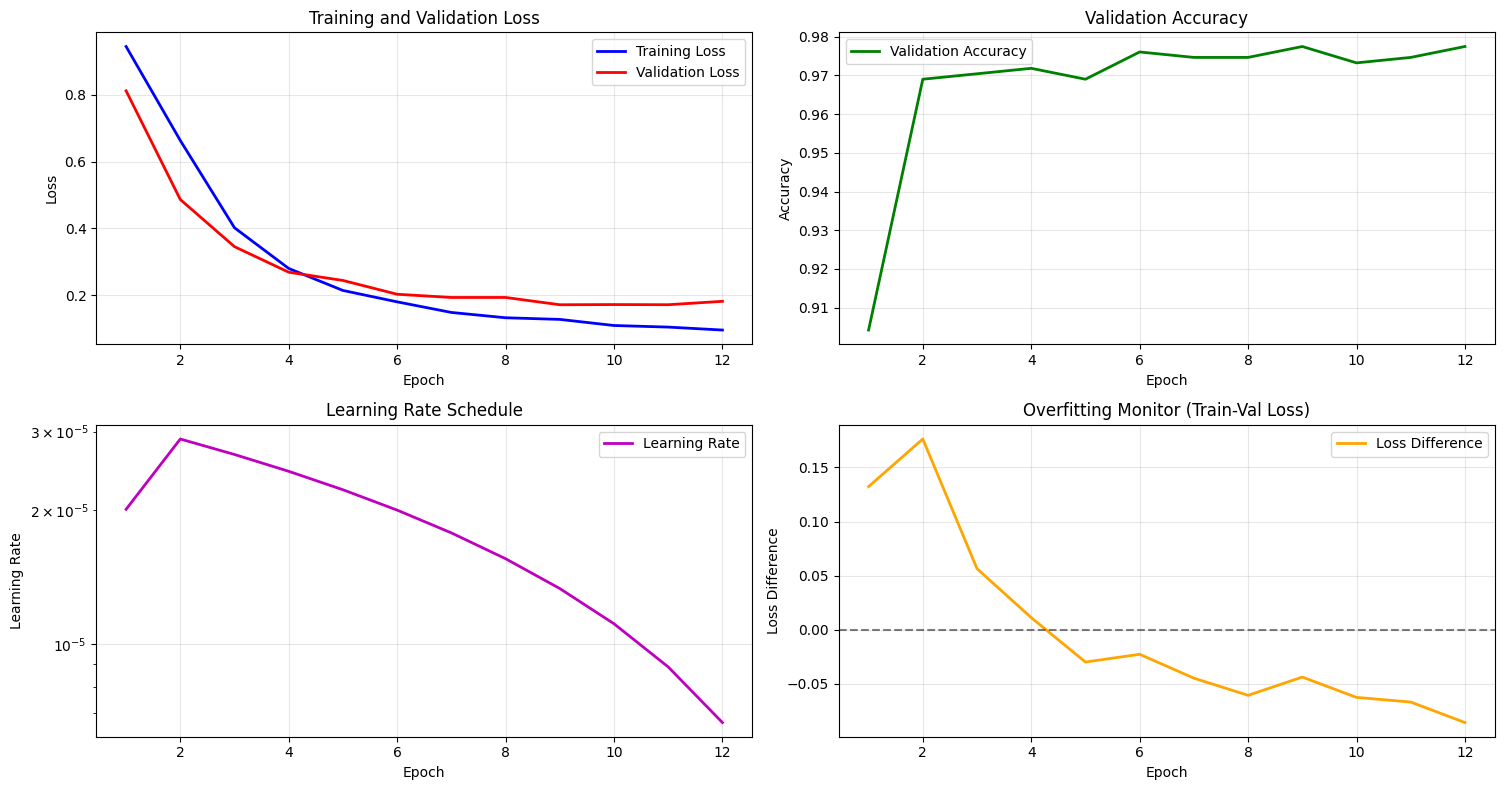

In [14]:
# Initialize tracking variables
train_losses: List[float] = []
val_losses: List[float] = []
val_accuracies: List[float] = []
learning_rates: List[float] = []

# Early stopping
early_stopping = EarlyStopping(patience=CONFIG['patience'], min_delta=1e-4)

# Setup live plotting
fig, axes, lines = setup_live_plot()

# Training loop
print(f"\n{'='*50}")
print("Starting Training with Live Monitoring")
print(f"{'='*50}")

progress_bar = tqdm(range(num_training_steps), desc="Total Progress")

for epoch in range(CONFIG['num_epochs']):
    print(f"\nEpoch {epoch + 1}/{CONFIG['num_epochs']}")
    
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, criterion, device)
    
    # Validate  
    val_loss, val_acc, val_probs, val_true = validate_epoch(model, val_loader, criterion, device)
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    learning_rates.append(lr_scheduler.get_last_lr()[0])
    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Learning Rate: {lr_scheduler.get_last_lr()[0]:.2e}")
    
    # Update live plot
    update_live_plot(epoch, train_losses, val_losses, val_accuracies, learning_rates, axes, lines)
    
    # Early stopping check
    if early_stopping(val_loss, model):
        print(f"Early stopping at epoch {epoch + 1}")
        break
    
    # Save best model
    if val_acc == max(val_accuracies):
        torch.save(model.state_dict(), OUTPUT_DIR / 'best_bert_tiny_amd.pth')
        print(f"💾 Saved new best model (acc={val_acc:.4f})")
    
    # Update progress bar
    steps_this_epoch = len(train_loader)
    progress_bar.update(steps_this_epoch)

progress_bar.close()

# Save final live plot
plt.savefig(OUTPUT_DIR / 'live_training_curves.png', dpi=300, bbox_inches='tight')

print(f"\nTraining completed!")
print(f"Best validation accuracy: {max(val_accuracies):.4f}")


## Comprehensive Evaluation and Metrics

In [15]:
# Load best model for evaluation
model.load_state_dict(torch.load(OUTPUT_DIR / 'best_bert_tiny_amd.pth', map_location=device))
print("Loaded best model for evaluation")

# Final evaluation
final_val_loss, final_val_acc, final_probs, final_labels = validate_epoch(
    model, val_loader, criterion, device
)

# Detailed metrics at threshold 0.5
threshold: float = 0.5
predictions = (np.array(final_probs) >= threshold).astype(int)

accuracy = accuracy_score(final_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(
    final_labels, predictions, average='binary', zero_division=0
)

print(f"\n{'='*50}")
print("FINAL EVALUATION RESULTS")
print(f"{'='*50}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Detailed classification report
print(f"\nDetailed Classification Report:")
print(classification_report(
    final_labels, predictions, 
    target_names=['Human', 'Machine'],
    digits=4
))

# Confusion matrix
cm = confusion_matrix(final_labels, predictions)
print(f"\nConfusion Matrix:")
print(f"       Predicted")
print(f"       Human  Machine")
print(f"Human    {cm[0,0]:4d}    {cm[0,1]:4d}")
print(f"Machine  {cm[1,0]:4d}    {cm[1,1]:4d}")

Loaded best model for evaluation

FINAL EVALUATION RESULTS
Accuracy:  0.9775
Precision: 0.9579
Recall:    0.9579
F1-Score:  0.9579

Detailed Classification Report:
              precision    recall  f1-score   support

       Human     0.9846    0.9846    0.9846       520
     Machine     0.9579    0.9579    0.9579       190

    accuracy                         0.9775       710
   macro avg     0.9713    0.9713    0.9713       710
weighted avg     0.9775    0.9775    0.9775       710


Confusion Matrix:
       Predicted
       Human  Machine
Human     512       8
Machine     8     182


## Visualization: Training Curves and Confusion Matrix

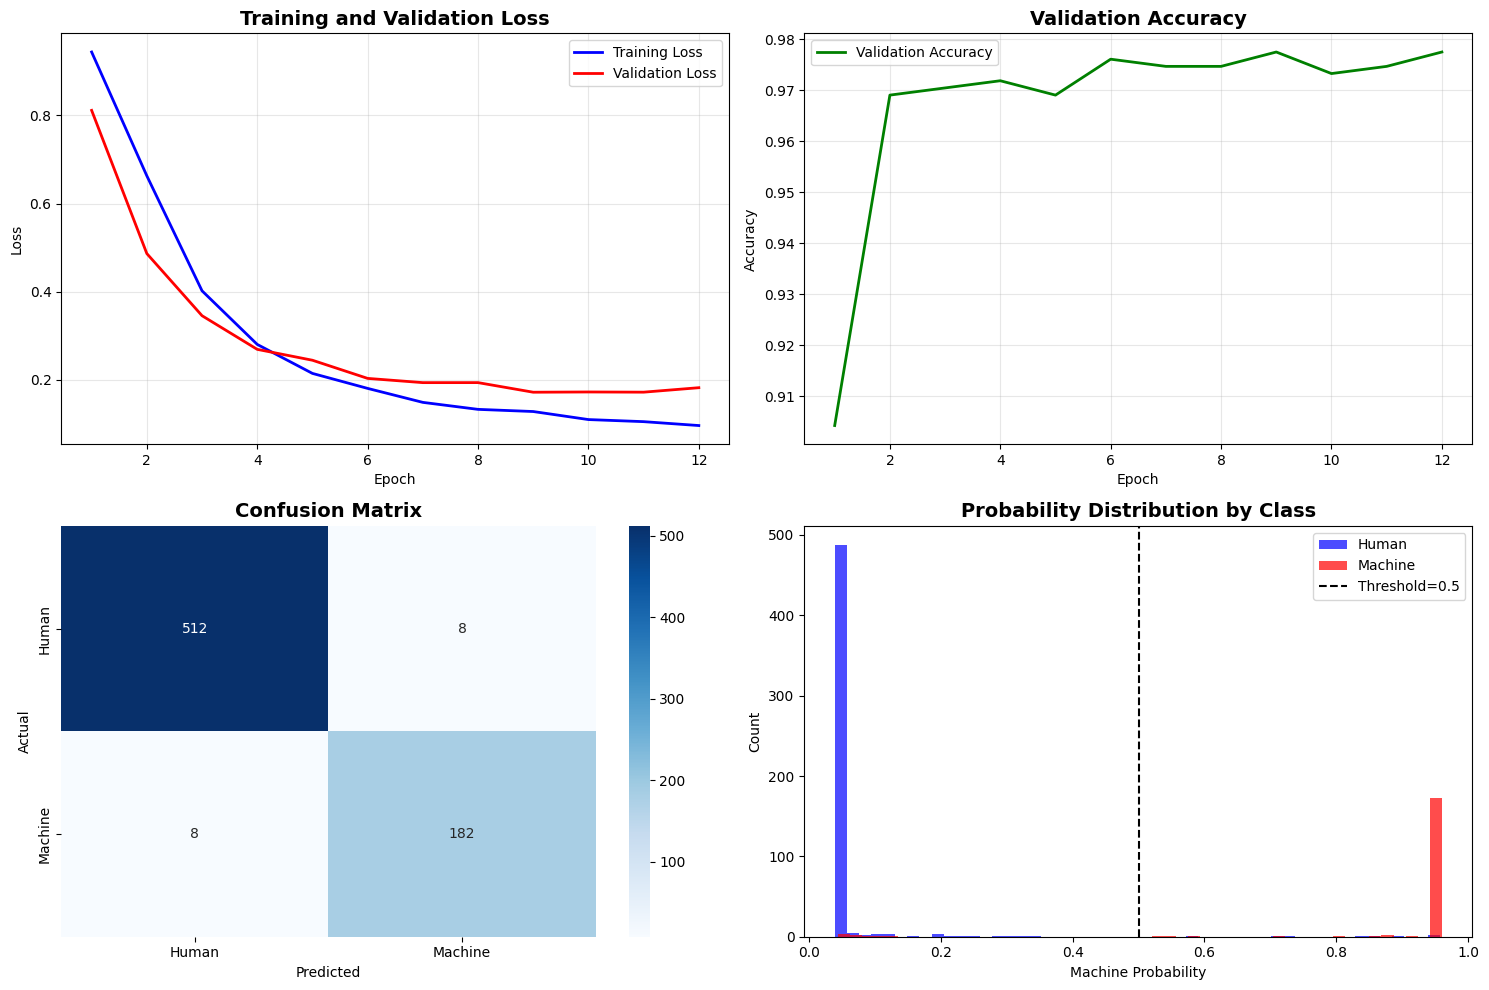

In [16]:
# Plot training curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

epochs = range(1, len(train_losses) + 1)

# Loss curves
ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curve
ax2.plot(epochs, val_accuracies, 'g-', label='Validation Accuracy', linewidth=2)
ax2.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Confusion matrix
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues', 
    xticklabels=['Human', 'Machine'], 
    yticklabels=['Human', 'Machine'],
    ax=ax3
)
ax3.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')

# Probability distribution
ax4.hist(
    [prob for i, prob in enumerate(final_probs) if final_labels[i] == 0], 
    bins=50, alpha=0.7, label='Human', color='blue'
)
ax4.hist(
    [prob for i, prob in enumerate(final_probs) if final_labels[i] == 1], 
    bins=50, alpha=0.7, label='Machine', color='red'
)
ax4.axvline(threshold, color='black', linestyle='--', label=f'Threshold={threshold}')
ax4.set_title('Probability Distribution by Class', fontsize=14, fontweight='bold')
ax4.set_xlabel('Machine Probability')
ax4.set_ylabel('Count')
ax4.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'bert_tiny_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


## Save Final Model and Results

In [17]:
# Save comprehensive model checkpoint
final_checkpoint = {
    'model_state_dict': model.state_dict(),
    'config': CONFIG,
    'tokenizer_name': CONFIG['model_name'],
    'model_config': model.config.to_dict(),
    'training_history': {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    },
    'final_metrics': {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm.tolist()
    },
    'pos_weight': pos_weight,
    'threshold': threshold
}

torch.save(final_checkpoint, OUTPUT_DIR / 'bert_tiny_amd_final.pth')

# Save detailed validation results
val_results_df = pd.DataFrame({
    'call_id': val_ids,
    'true_label': final_labels,
    'predicted_label': predictions,
    'machine_probability': final_probs,
    'correct': (np.array(final_labels) == np.array(predictions)).astype(int),
    'user_text': [text[:200] + ('...' if len(text) > 200 else '') for text in val_texts]
})

val_results_df.to_csv(OUTPUT_DIR / 'validation_detailed_results.csv', index=False)

print(f"\n{'='*50}")
print("FILES SAVED")
print(f"{'='*50}")
for file_path in OUTPUT_DIR.iterdir():
    print(f"📁 {file_path.name}")


FILES SAVED
📁 bert_tiny_amd_final.pth
📁 live_training_curves.png
📁 bert_tiny_analysis.png
📁 best_bert_tiny_amd.pth
📁 validation_detailed_results.csv


## Inference Function for New Transcripts

In [18]:
@torch.no_grad()
def predict_transcript(
    transcript: List[Dict[str, Any]], 
    model_path: str = None,
    threshold: float = 0.5
) -> Tuple[bool, float, str]:
    """
    Predict if a transcript is from an answering machine
    
    Args:
        transcript: List of utterances with speaker and content
        model_path: Path to saved model (if None, uses current model)
        threshold: Threshold for binary classification
        
    Returns:
        is_machine: Boolean prediction
        probability: Float probability of being machine (0-1)
        user_text: Extracted user text used for prediction
    """
    
    # Load model if path provided
    if model_path:
        checkpoint = torch.load(model_path, map_location=device)
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)
    
    model.eval()
    
    # Extract user text
    user_text = extract_user_text(transcript)
    
    if not user_text.strip():
        return False, 0.0, ""
    
    # Tokenize
    encoding = tokenizer(
        user_text,
        add_special_tokens=True,
        max_length=CONFIG['max_length'],
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    # Move to device and predict
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logit = outputs.logits.squeeze(-1)  # Remove last dimension
    machine_prob = torch.sigmoid(logit).item()  # Apply sigmoid to get probability
    
    is_machine = machine_prob >= threshold
    
    return is_machine, machine_prob, user_text

# Test inference on example transcript
example_transcript = [
    {
        "timestamp": "2025-08-21 11:38:19", 
        "speaker": "assistant", 
        "content": "Hello, this is Priya from ElevateNow. Am I speaking with Pooja sahni Sahni?"
    },
    {
        "timestamp": "2025-08-21 11:38:21", 
        "speaker": "user", 
        "content": "Yes?"
    },
    {
        "timestamp": "2025-08-21 11:38:21", 
        "speaker": "assistant", 
        "content": "Great! I noticed you were checking out our Nano plan but didn't complete the payment."
    }
]

is_machine, prob, user_text = predict_transcript(example_transcript)

print(f"\n{'='*50}")
print("EXAMPLE PREDICTION")
print(f"{'='*50}")
print(f"User text: '{user_text}'")
print(f"Prediction: {'Machine' if is_machine else 'Human'}")
print(f"Confidence: {prob:.4f}")



EXAMPLE PREDICTION
User text: 'Yes?'
Prediction: Human
Confidence: 0.0391


## Model Analysis and Comparison with Rule-Based System

In [19]:
# Compare BERT predictions with rule-based system on validation set
rule_based_predictions: List[int] = []
bert_predictions: List[int] = predictions.tolist()

print("Comparing BERT vs Rule-based predictions...")
for i, text in enumerate(tqdm(val_texts, desc="Rule-based inference")):
    is_machine_rule, _ = fuzzy_amd._detect_machine(text)
    rule_based_predictions.append(1 if is_machine_rule else 0)

# Calculate agreement metrics
agreement = np.array(bert_predictions) == np.array(rule_based_predictions)
agreement_rate = agreement.mean()

print(f"\n{'='*50}")
print("BERT vs RULE-BASED COMPARISON")
print(f"{'='*50}")
print(f"Agreement rate: {agreement_rate:.4f} ({agreement.sum()}/{len(agreement)})")

# Rule-based performance
rule_accuracy = accuracy_score(final_labels, rule_based_predictions)
rule_precision, rule_recall, rule_f1, _ = precision_recall_fscore_support(
    final_labels, rule_based_predictions, average='binary', zero_division=0
)

print(f"\nRule-based performance:")
print(f"  Accuracy:  {rule_accuracy:.4f}")
print(f"  Precision: {rule_precision:.4f}")  
print(f"  Recall:    {rule_recall:.4f}")
print(f"  F1-Score:  {rule_f1:.4f}")

print(f"\nBERT performance:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

# Cases where they disagree
disagreement_indices = np.where(~agreement)[0]
print(f"\nDisagreement cases: {len(disagreement_indices)}")

if len(disagreement_indices) > 0:
    disagreement_df = pd.DataFrame({
        'call_id': [val_ids[i] for i in disagreement_indices[:10]],  # First 10
        'true_label': [final_labels[i] for i in disagreement_indices[:10]],
        'bert_pred': [bert_predictions[i] for i in disagreement_indices[:10]],
        'rule_pred': [rule_based_predictions[i] for i in disagreement_indices[:10]], 
        'bert_prob': [final_probs[i] for i in disagreement_indices[:10]],
        'user_text': [val_texts[i][:150] + '...' for i in disagreement_indices[:10]]
    })
    
    print(f"\nFirst 10 disagreement cases:")
    print(disagreement_df.to_string(index=False))

Comparing BERT vs Rule-based predictions...


Rule-based inference: 100%|██████████| 710/710 [00:11<00:00, 61.00it/s] 


BERT vs RULE-BASED COMPARISON
Agreement rate: 0.9775 (694/710)

Rule-based performance:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

BERT performance:
  Accuracy:  0.9775
  Precision: 0.9579
  Recall:    0.9579
  F1-Score:  0.9579

Disagreement cases: 16

First 10 disagreement cases:
                             call_id  true_label  bert_pred  rule_pred  bert_prob                                                                                                                                                 user_text
26d86868-09d4-48e5-95bc-d12483d30c4c           1          0          1   0.044663 Hello. Yes. I am ready to drop to your executive when I get executive then इसमें नहीं, लेकिन मेरी बात आप ग्राहक सेवा अधिकारी से करवाइए. कभी भी? Sir तो...
11e9e0b2-bf44-4673-96e2-3d3a27ef89e5           1          0          1   0.081776 Hello? Express का यह trending गाना तो आपने सुना ही होगा. Oh my god, अरे 01:02 out out के direction में, उमेश शुक्ला Please f

## Summary and Next Steps

In [20]:
print(f"\n{'='*60}")
print("TRAINING SUMMARY")
print(f"{'='*60}")

print(f"Dataset Statistics:")
print(f"  Total samples: {len(train_texts) + len(val_texts):,}")
print(f"  Training: {len(train_texts):,}")
print(f"  Validation: {len(val_texts):,}")
print(f"  Machine calls: {sum(train_labels + val_labels):,} ({(sum(train_labels + val_labels)/(len(train_texts) + len(val_texts)))*100:.1f}%)")

print(f"\nModel Performance:")
print(f"  Final Validation Accuracy: {accuracy:.4f}")
print(f"  Final Validation F1-Score: {f1:.4f}")
print(f"  Agreement with Rule-based: {agreement_rate:.4f}")

print(f"\nArchitecture Details:")
print(f"  Model: {CONFIG['model_name']}")
print(f"  Output: Single logit (1 neuron)")
print(f"  Activation: Sigmoid (in BCEWithLogitsLoss)")
print(f"  Loss: BCEWithLogitsLoss with pos_weight={pos_weight:.3f}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Training Epochs: {len(train_losses)}")
print(f"  Early Stopping: {'Yes' if early_stopping.early_stop else 'No'}")

print(f"\nFiles Generated:")
for file_path in sorted(OUTPUT_DIR.iterdir()):
    size_kb = file_path.stat().st_size / 1024
    print(f"  📁 {file_path.name} ({size_kb:.1f} KB)")

print(f"\n{'='*60}")
print("NEXT STEPS")
print(f"{'='*60}")
print("1. Upload model to HuggingFace Hub for production deployment")
print("2. Integrate with VoiceX AMD Manager service")
print("3. Implement progressive utterance analysis (1→2→3 utterances)")
print("4. Monitor performance on live call data")
print("5. Set up retraining pipeline for model updates")



TRAINING SUMMARY
Dataset Statistics:
  Total samples: 3,548
  Training: 2,838
  Validation: 710
  Machine calls: 951 (26.8%)

Model Performance:
  Final Validation Accuracy: 0.9775
  Final Validation F1-Score: 0.9579
  Agreement with Rule-based: 0.9775

Architecture Details:
  Model: prajjwal1/bert-tiny
  Output: Single logit (1 neuron)
  Activation: Sigmoid (in BCEWithLogitsLoss)
  Loss: BCEWithLogitsLoss with pos_weight=2.729
  Parameters: 4,386,049
  Training Epochs: 12
  Early Stopping: Yes

Files Generated:
  📁 bert_tiny_amd_final.pth (17152.7 KB)
  📁 bert_tiny_analysis.png (339.5 KB)
  📁 best_bert_tiny_amd.pth (17149.5 KB)
  📁 live_training_curves.png (360.8 KB)
  📁 validation_detailed_results.csv (102.3 KB)

NEXT STEPS
1. Upload model to HuggingFace Hub for production deployment
2. Integrate with VoiceX AMD Manager service
3. Implement progressive utterance analysis (1→2→3 utterances)
4. Monitor performance on live call data
5. Set up retraining pipeline for model updates


## Production Deployment Code

In [21]:
def create_production_inference_code():
    """Generate production-ready inference code"""
    
    production_code = '''
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from typing import List, Dict, Any, Tuple

class ProductionAMDClassifier:
    """Production-ready AMD classifier using BERT-Tiny with single logit output"""
    
    def __init__(self, model_path: str, device: str = 'cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        
        # Load model and tokenizer
        checkpoint = torch.load(model_path, map_location=self.device)
        config = checkpoint['config']
        
        self.tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
        self.model = AutoModelForSequenceClassification.from_pretrained(
            config['model_name'], num_labels=1  # Single logit output
        )
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)
        self.model.eval()
        
        self.max_length = config['max_length']
        self.threshold = checkpoint.get('threshold', 0.5)
        
        print(f"Loaded AMD classifier on {self.device}")
        print(f"Architecture: Single logit + BCEWithLogitsLoss")
    
    @torch.no_grad()
    def predict(self, transcript: List[Dict[str, Any]]) -> Tuple[bool, float, str]:
        """Predict if transcript is from answering machine"""
        
        # Extract user text
        user_texts = []
        for utterance in transcript:
            if utterance.get("speaker", "").lower() == "user":
                content = utterance.get("content", "").strip()
                if content:
                    user_texts.append(content)
        
        user_text = " ".join(user_texts)
        
        if not user_text.strip():
            return False, 0.0, ""
        
        # Tokenize and predict
        encoding = self.tokenizer(
            user_text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logit = outputs.logits.squeeze(-1)  # Single logit value
        machine_prob = torch.sigmoid(logit).item()  # Apply sigmoid
        
        is_machine = machine_prob >= self.threshold
        
        return is_machine, machine_prob, user_text
    
    def predict_progressive(self, utterances: List[str], 
                          stage_thresholds: List[float] = [0.95, 0.85, 0.75]) -> Dict[str, Any]:
        """
        Progressive utterance analysis for production AMD system
        
        Args:
            utterances: List of user utterance texts
            stage_thresholds: Confidence thresholds for each stage
            
        Returns:
            Dictionary with decision, confidence, stage, and metadata
        """
        results = {
            'final_decision': False,
            'confidence': 0.0,
            'decision_stage': 0,
            'stage_results': [],
            'utterances_processed': 0
        }
        
        for stage, utterance_count in enumerate([1, 2, 3], 1):
            if len(utterances) < utterance_count:
                break
                
            # Combine utterances up to current stage
            combined_text = " ".join(utterances[:utterance_count])
            
            # Get prediction
            is_machine, confidence, _ = self.predict([
                {"speaker": "user", "content": combined_text}
            ])
            
            stage_result = {
                'stage': stage,
                'utterances': utterance_count,
                'confidence': confidence,
                'text': combined_text[:100] + '...'
            }
            results['stage_results'].append(stage_result)
            results['utterances_processed'] = utterance_count
            
            # Check if confidence meets threshold for this stage
            if stage <= len(stage_thresholds) and confidence >= stage_thresholds[stage-1]:
                results['final_decision'] = is_machine
                results['confidence'] = confidence
                results['decision_stage'] = stage
                break
                
            # Final stage - make decision regardless of confidence
            if stage == 3:
                results['final_decision'] = is_machine
                results['confidence'] = confidence
                results['decision_stage'] = stage
        
        return results

# Usage example:
# classifier = ProductionAMDClassifier('output/bert_tiny_amd_final.pth')
# 
# # Single prediction
# is_machine, confidence, user_text = classifier.predict(transcript)
# 
# # Progressive analysis (for production system)
# utterances = ["Hello?", "Yes, this is John", "Sorry, could you repeat that?"]
# result = classifier.predict_progressive(utterances)
'''
    
    with open(OUTPUT_DIR / 'production_inference.py', 'w') as f:
        f.write(production_code)
    
    print("Generated production inference code: output/production_inference.py")

create_production_inference_code()

print("\n🎉 BERT-Tiny AMD Classifier training completed successfully!")

Generated production inference code: output/production_inference.py

🎉 BERT-Tiny AMD Classifier training completed successfully!
